In [1]:
import os

import numpy as np
import pandas as pd

from shapely.geometry import LineString
from shapely.geometry import Point, MultiPoint, MultiLineString
from shapely.ops import linemerge, nearest_points

import geopandas as gpd
from geopandas import GeoDataFrame
from centerline.geometry import Centerline

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

C:\Users\dee\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
crs = {'init': 'epsg:3627'} #local crs

## Get Sidewalk Centerlines

In [3]:
df = gpd.read_file('../data/sample.shp')

In [108]:
df.crs = crs

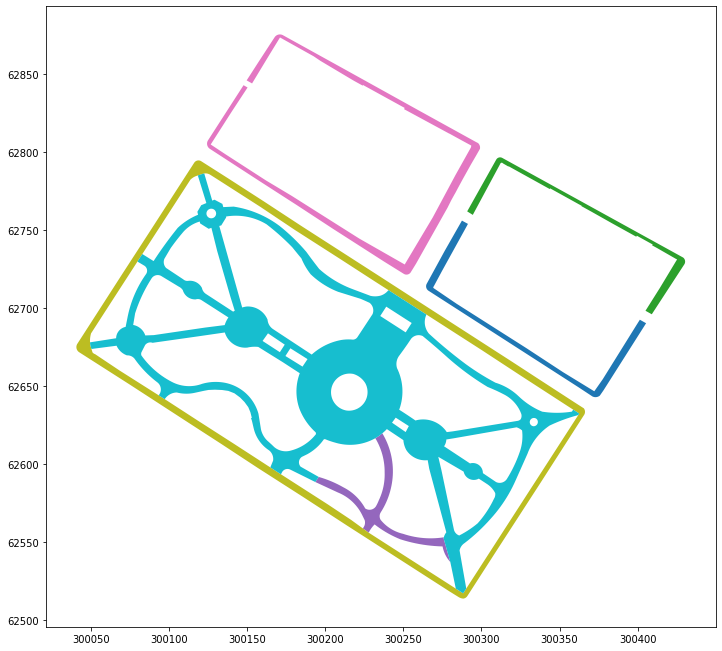

In [109]:
df.plot(figsize=(12, 12), cmap='tab10')

In [110]:
df_dissolved = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df.unary_union.geoms]))

In [111]:
df_exploded = gpd.GeoDataFrame(df_dissolved.geometry.explode())

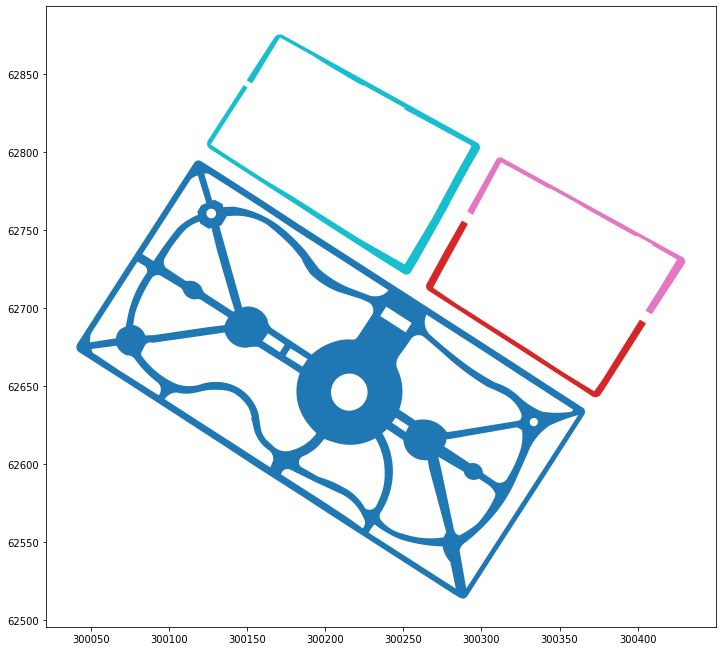

In [112]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [113]:
df_exploded['centerlines'] = df_exploded.progress_apply(lambda row: Centerline(row.geometry), axis=1)

In [114]:
df_exploded = df_exploded.set_geometry('centerlines')

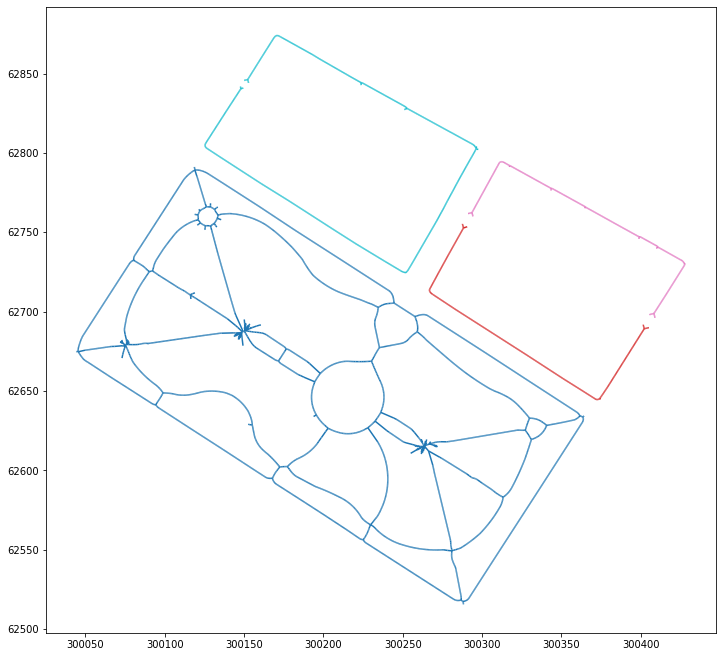

In [115]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

## Remove Short Line Ends

In [116]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(linemerge)

In [117]:
def remove_short_lines(line):
    
    if line.type == 'MultiLineString':
        
        passing_lines = []
    
        for i, linestring in enumerate(line):
            
            other_lines = MultiLineString([x for j, x in enumerate(line) if j != i])
            
            p0 = Point(linestring.coords[0])
            p1 = Point(linestring.coords[-1])
            
            is_deadend = False
            
            if p0.disjoint(other_lines): is_deadend = True
            if p1.disjoint(other_lines): is_deadend = True
            
            if not is_deadend or linestring.length > 5:                
                passing_lines.append(linestring)
            
        return MultiLineString(passing_lines)
            
    if line.type == 'LineString':
        return line

In [118]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(remove_short_lines)

In [119]:
df_exploded.head()

,,geometry,centerlines
0,0,"POLYGON ((300129.324 62788.206, 300133.617 627...","MULTILINESTRING ((300044.455 62674.781, 300044..."
1,0,"POLYGON ((300352.245 62658.721, 300372.286 626...","MULTILINESTRING ((300374.215 62645.296, 300374..."
2,0,"POLYGON ((300318.442 62793.146, 300323.717 627...","MULTILINESTRING ((300293.667 62762.429, 300293..."
3,0,"POLYGON ((300174.039 62873.897, 300177.876 628...","MULTILINESTRING ((300148.074 62840.550, 300148..."


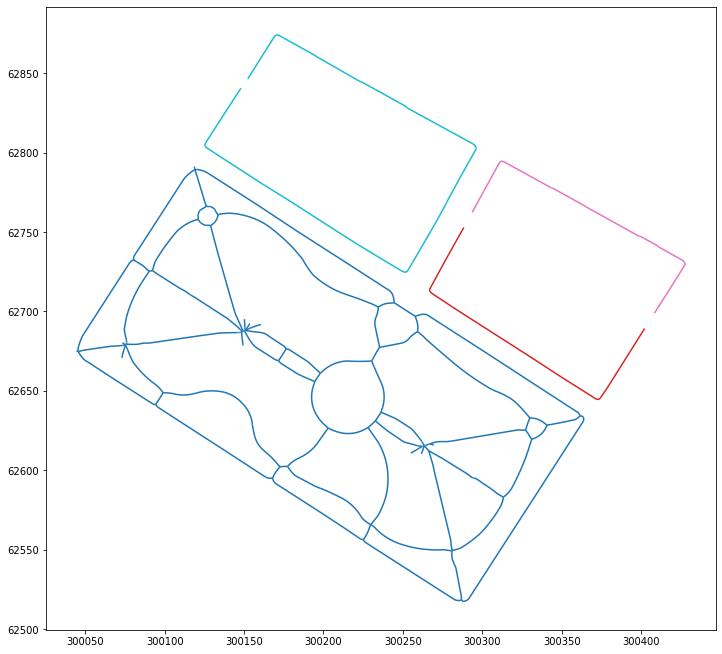

In [15]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

## Get Sidewalk Widths

In [139]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(lambda row: row.simplify(1, preserve_topology=True))

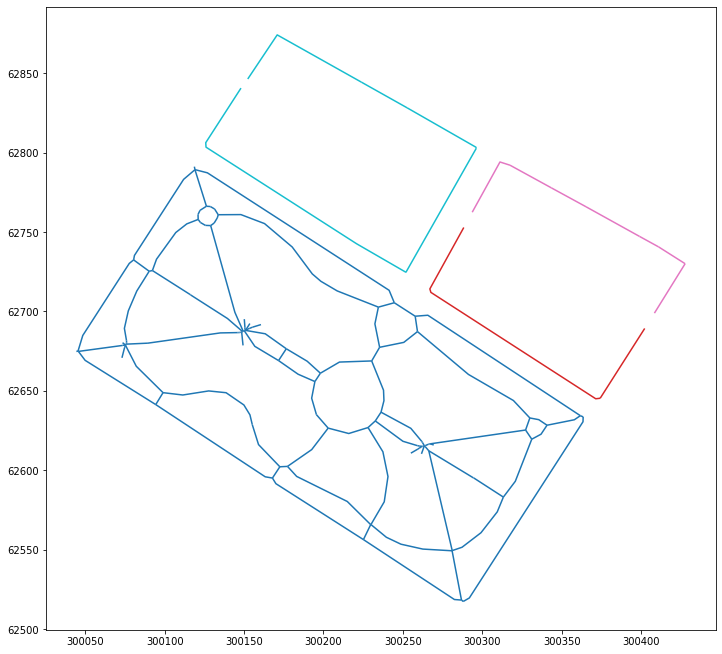

In [140]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [16]:
def linestring_to_segments(linestring):
    return [LineString([linestring.coords[i], linestring.coords[i+1]]) for i in range(len(linestring.coords) - 1)]

In [17]:
def get_segments(line):
    
    line_segments = []

    if line.type == 'MultiLineString':
        
        for linestring in line.geoms:
            
            line_segments.extend(linestring_to_segments(linestring))

    if line.type == 'LineString':
        
        line_segments.extend(linestring_to_segments(line))

    return line_segments

In [18]:
df_exploded.head(1)

,,geometry,centerlines
0,0,"POLYGON ((300129.324 62788.206, 300133.617 627...","MULTILINESTRING ((300044.455 62674.781, 300044..."


In [19]:
df_exploded['segments'] = df_exploded['centerlines'].progress_apply(get_segments)
df_exploded.head(1)

,,geometry,centerlines,segments
0,0,"POLYGON ((300129.324 62788.206, 300133.617 627...","MULTILINESTRING ((300044.455 62674.781, 300044...",[LINESTRING (300044.4548079385 62674.780597435...


In [20]:
def interpolate_by_distance(linestring):
    
    distance = 1
    all_points = []
    count = round(linestring.length / distance) + 1
    
    if count == 1:
        all_points.append(linestring.interpolate(linestring.length / 2))
    
    else:
        for i in range(count):
            all_points.append(linestring.interpolate(distance * i))
    
    return all_points

def interpolate(line):
    
    if line.type == 'MultiLineString':
        
        all_points = []
        
        for linestring in line:
            all_points.extend(interpolate_by_distance(linestring))
        
        return MultiPoint(all_points)
            
    if line.type == 'LineString':
        return MultiPoint(interpolate_by_distance(line))
    
    
def polygon_to_multilinestring(polygon):

    return MultiLineString([polygon.exterior] + [line for line in polygon.interiors])
    

def get_avg_distances(row):
    
    avg_distances = []
    
    sidewalk_lines = polygon_to_multilinestring(row.geometry)
    
    for segment in row.segments:
        
        points = interpolate(segment)
        
        distances = []
        
        for point in points:
            p1, p2 = nearest_points(sidewalk_lines, point)
            distances.append(p1.distance(p2))
            
        avg_distances.append(sum(distances) / len(distances))
        
    return avg_distances

In [21]:
df_exploded['avg_distances'] = df_exploded.progress_apply(lambda row: get_avg_distances(row), axis=1)
df_exploded.head(1)

,,geometry,centerlines,segments,avg_distances
0,0,"POLYGON ((300129.324 62788.206, 300133.617 627...","MULTILINESTRING ((300044.455 62674.781, 300044...",[LINESTRING (300044.4548079385 62674.780597435...,"[3.944050797707597, 3.9458902991567, 3.9476483..."


In [22]:
data = {'geometry': [], 'width': []}

for i, row in df_exploded.iterrows():
    
    for segment in row.segments:
        data['geometry'].append(segment)
    
    for distance in row.avg_distances:
        data['width'].append(distance * 2)
        
df_segments = pd.DataFrame(data)
df_segments = GeoDataFrame(df_segments, crs=crs, geometry='geometry')
df_segments.head(1)

,geometry,width
0,"LINESTRING (300044.455 62674.781, 300044.457 6...",7.888102


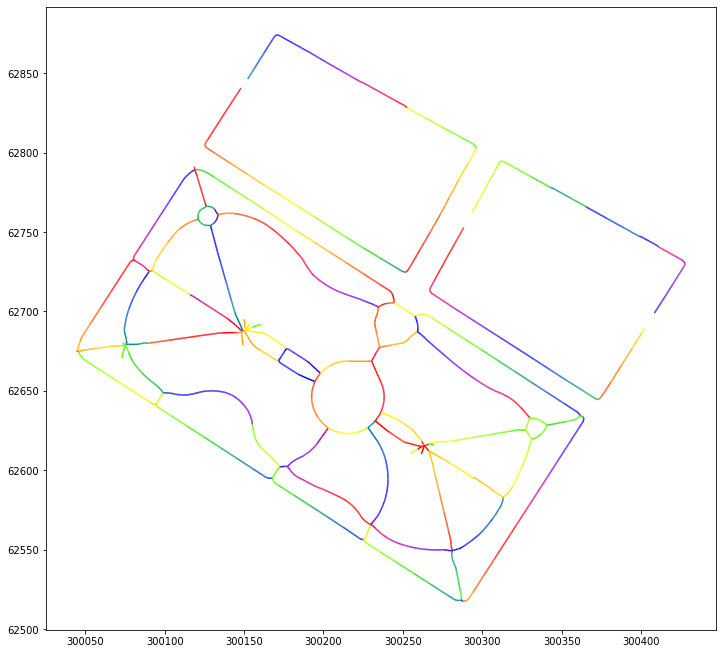

In [23]:
df_segments.plot(figsize=(12, 12), cmap='prism')

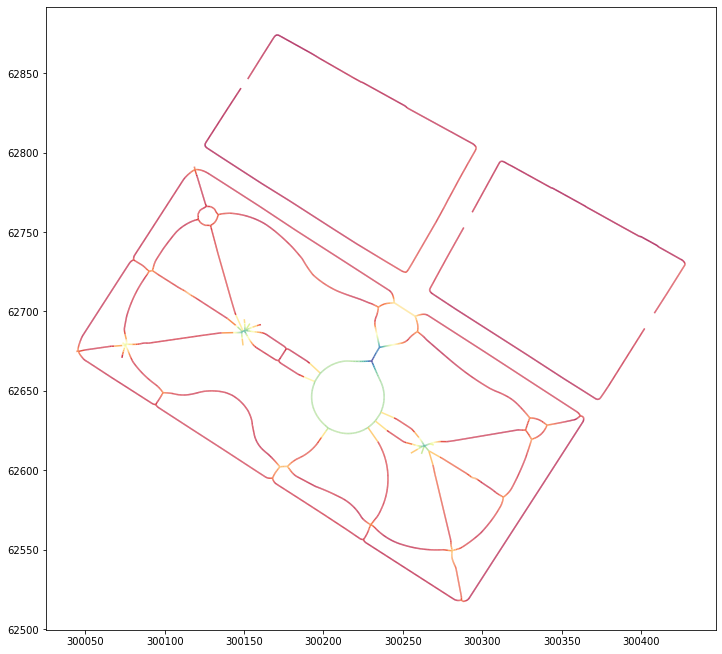

In [24]:
df_segments.plot(figsize=(12, 12), column='width', cmap='Spectral')

In [25]:
df_segments['width'] = df_segments['width'] * 3.28084

In [26]:
df_segments['width'] = round(df_segments['width'] * 10) / 10
df_segments.head()

,geometry,width
0,"LINESTRING (300044.455 62674.781, 300044.457 6...",25.9
1,"LINESTRING (300044.459 62674.781, 300044.457 6...",25.9
2,"LINESTRING (300044.459 62674.781, 300044.462 6...",25.9
3,"LINESTRING (300044.462 62674.782, 300044.639 6...",26.3
4,"LINESTRING (300044.639 62674.822, 300044.706 6...",26.9


In [153]:
df_projected = df_segments.to_crs('EPSG:4326')
df_projected.crs

'EPSG:4326'

In [32]:
with open('output.geojson', 'w') as f:
    f.write(df_projected.to_json())

## Merge Multiple

In [34]:
df_staten_island = gpd.read_file('./boroughs/staten_island.geojson')
df_manhattan = gpd.read_file('./boroughs/manhattan.geojson')
df_brooklyn_queens = gpd.read_file('./boroughs/brooklyn_queens.geojson')
df_bronx = gpd.read_file('./boroughs/bronx.geojson')

In [35]:
df_all = gpd.GeoDataFrame( pd.concat( [df_staten_island, df_manhattan, df_brooklyn_queens, df_bronx], ignore_index=True) )

In [36]:
df_all.head(5)

,id,width,geometry
0,0,8.3,"LINESTRING (-74.24158 40.49860, -74.24195 40.4..."
1,1,8.8,"LINESTRING (-74.24195 40.49829, -74.24205 40.4..."
2,2,9.0,"LINESTRING (-74.24205 40.49823, -74.24216 40.4..."
3,3,7.2,"LINESTRING (-74.24216 40.49818, -74.24228 40.4..."
4,4,6.4,"LINESTRING (-74.24228 40.49816, -74.24239 40.4..."


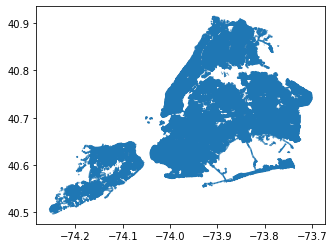

In [37]:
df_all.plot()

In [38]:
with open('sidewalks_nyc.geojson', 'w') as f:
    f.write(df_all.to_json())

## Summary Statistics
This section takes the geojson includng sidewalk widths and produces some summary statistics. It also includes the ability to produces these statistics based on geographic boundaries, such as City Council Districts.

In [4]:
# the city council data was sourced here: https://data.cityofnewyork.us/City-Government/City-Council-Districts/yusd-j4xi
df_cc = gpd.read_file('../data/City Council Districts/geo_export_dc8afe38-6e4a-4aa5-9b47-d52c345ba27b.shp')

In [5]:
df_cc = df_cc.to_crs(crs)

C:\Users\dee\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


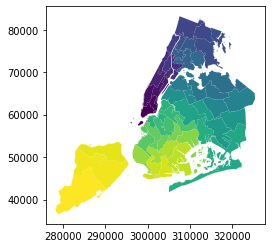

In [6]:
df_cc.plot(column='coun_dist')

In [7]:
df_nyc = gpd.read_file('../sidewalkwidths_nyc.geojson')

In [8]:
df_nyc = df_nyc.to_crs(crs)

C:\Users\dee\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


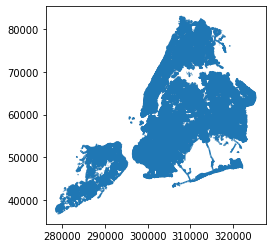

In [9]:
df_nyc.plot()

In [10]:
overlayed = gpd.overlay(df_nyc, df_cc, how='intersection')

In [11]:
overlayed.head()

,id,width,coun_dist,shape_area,shape_leng,geometry
0,0,8.3,51.0,6.556487e+08,195521.334267,"LINESTRING (279521.540 36888.192, 279489.883 3..."
1,1,8.8,51.0,6.556487e+08,195521.334267,"LINESTRING (279489.883 36853.097, 279481.434 3..."
2,2,9.0,51.0,6.556487e+08,195521.334267,"LINESTRING (279481.434 36846.548, 279471.490 3..."
3,3,7.2,51.0,6.556487e+08,195521.334267,"LINESTRING (279471.490 36841.598, 279461.677 3..."
4,4,6.4,51.0,6.556487e+08,195521.334267,"LINESTRING (279461.677 36839.369, 279452.533 3..."


In [12]:
overlayed['length'] = df_nyc['geometry'].length
overlayed.head()

,id,width,coun_dist,shape_area,shape_leng,geometry,length
0,0,8.3,51.0,6.556487e+08,195521.334267,"LINESTRING (279521.540 36888.192, 279489.883 3...",47.263221
1,1,8.8,51.0,6.556487e+08,195521.334267,"LINESTRING (279489.883 36853.097, 279481.434 3...",10.690497
2,2,9.0,51.0,6.556487e+08,195521.334267,"LINESTRING (279481.434 36846.548, 279471.490 3...",11.107258
3,3,7.2,51.0,6.556487e+08,195521.334267,"LINESTRING (279471.490 36841.598, 279461.677 3...",10.062857
4,4,6.4,51.0,6.556487e+08,195521.334267,"LINESTRING (279461.677 36839.369, 279452.533 3...",9.361866


In [47]:
def meters_to_miles(value):
    return value * 0.000621371 

In [48]:
overlayed['length'] = overlayed['length'].apply(meters_to_miles)
overlayed.head()

,id,width,coun_dist,shape_area,shape_leng,geometry,length,bin,group
0,0,8.3,51.0,6.556487e+08,195521.334267,"LINESTRING (279521.540 36888.192, 279489.883 3...",0.029368,"[6.0, 9.0)",6.0
1,1,8.8,51.0,6.556487e+08,195521.334267,"LINESTRING (279489.883 36853.097, 279481.434 3...",0.006643,"[6.0, 9.0)",6.0
2,2,9.0,51.0,6.556487e+08,195521.334267,"LINESTRING (279481.434 36846.548, 279471.490 3...",0.006902,"[9.0, 12.0)",9.0
3,3,7.2,51.0,6.556487e+08,195521.334267,"LINESTRING (279471.490 36841.598, 279461.677 3...",0.006253,"[6.0, 9.0)",6.0
4,4,6.4,51.0,6.556487e+08,195521.334267,"LINESTRING (279461.677 36839.369, 279452.533 3...",0.005817,"[6.0, 9.0)",6.0


In [49]:
overlayed.shape #number of sidewalk lines

(463895, 9)

In [50]:
overlayed['length'].sum() #total length of sidewalks

10665.056112416834

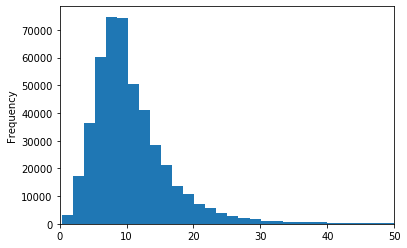

In [51]:
overlayed['width'].plot.hist(bins=100, xlim=(0,50)) #distribution of widths

In [52]:
bins = [0, 6, 9, 12, 15, 18, 21, float('inf')]
overlayed['bin'] = pd.cut(df_nyc['width'], bins, right=False)
overlayed.head()

,id,width,coun_dist,shape_area,shape_leng,geometry,length,bin,group
0,0,8.3,51.0,6.556487e+08,195521.334267,"LINESTRING (279521.540 36888.192, 279489.883 3...",0.029368,"[6.0, 9.0)",6.0
1,1,8.8,51.0,6.556487e+08,195521.334267,"LINESTRING (279489.883 36853.097, 279481.434 3...",0.006643,"[6.0, 9.0)",6.0
2,2,9.0,51.0,6.556487e+08,195521.334267,"LINESTRING (279481.434 36846.548, 279471.490 3...",0.006902,"[9.0, 12.0)",9.0
3,3,7.2,51.0,6.556487e+08,195521.334267,"LINESTRING (279471.490 36841.598, 279461.677 3...",0.006253,"[6.0, 9.0)",6.0
4,4,6.4,51.0,6.556487e+08,195521.334267,"LINESTRING (279461.677 36839.369, 279452.533 3...",0.005817,"[6.0, 9.0)",6.0


In [53]:
def parse_range(group_range):
    return group_range.left

In [54]:
overlayed['group'] = overlayed['bin'].apply(parse_range)
overlayed.head()

,id,width,coun_dist,shape_area,shape_leng,geometry,length,bin,group
0,0,8.3,51.0,6.556487e+08,195521.334267,"LINESTRING (279521.540 36888.192, 279489.883 3...",0.029368,"[6.0, 9.0)",6.0
1,1,8.8,51.0,6.556487e+08,195521.334267,"LINESTRING (279489.883 36853.097, 279481.434 3...",0.006643,"[6.0, 9.0)",6.0
2,2,9.0,51.0,6.556487e+08,195521.334267,"LINESTRING (279481.434 36846.548, 279471.490 3...",0.006902,"[9.0, 12.0)",9.0
3,3,7.2,51.0,6.556487e+08,195521.334267,"LINESTRING (279471.490 36841.598, 279461.677 3...",0.006253,"[6.0, 9.0)",6.0
4,4,6.4,51.0,6.556487e+08,195521.334267,"LINESTRING (279461.677 36839.369, 279452.533 3...",0.005817,"[6.0, 9.0)",6.0


In [55]:
g = overlayed.groupby(overlayed['group']).agg({'length': 'sum'})
g

,length
group,
0.0,1866.685168
6.0,3955.853926
9.0,2774.628836
12.0,1249.041146
15.0,475.744130
18.0,189.583860
21.0,153.519046


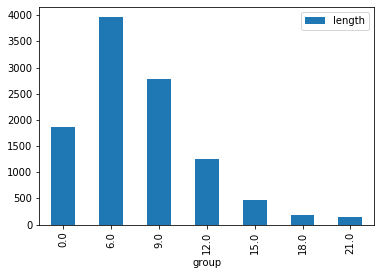

In [56]:
g.plot.bar()

In [57]:
g_districts = overlayed.groupby(['coun_dist', 'group']).agg({'length': 'sum'})
g_districts

length
coun_dist group           
1.0       0.0    12.738621
          6.0    34.145524
          9.0    44.262430
          12.0   30.102946
          15.0   13.403844
...                    ...
51.0      9.0    85.301451
          12.0   13.642646
          15.0    3.859937
          18.0    1.210413
          21.0    1.996823

[357 rows x 1 columns]

In [58]:
g_districts = g_districts.unstack(1)
g_districts.head()

length                                                         \
group           0.0        6.0        9.0        12.0       15.0       18.0   
coun_dist                                                                     
1.0        12.738621  34.145524  44.262430  30.102946  13.403844   6.178131   
2.0        11.086524  20.841493  25.233660  14.020183   7.322854   3.809225   
3.0         5.973459  15.894306  25.488445  27.308501  20.943593  10.172653   
4.0         4.567558  17.284691  30.840746  31.388118  13.651365   6.422632   
5.0         3.505804   8.385150  11.342597   9.982028   8.433580   3.385553   

                     
group          21.0  
coun_dist            
1.0        9.828779  
2.0        5.545370  
3.0        6.656233  
4.0        3.964509  
5.0        1.176377

In [59]:
g_districts.columns = g_districts.columns.droplevel(0)
g_districts.head()

group,0.0,6.0,9.0,12.0,15.0,18.0,21.0
coun_dist,,,,,,,
1.0,12.738621,34.145524,44.262430,30.102946,13.403844,6.178131,9.828779
2.0,11.086524,20.841493,25.233660,14.020183,7.322854,3.809225,5.545370
3.0,5.973459,15.894306,25.488445,27.308501,20.943593,10.172653,6.656233
4.0,4.567558,17.284691,30.840746,31.388118,13.651365,6.422632,3.964509
5.0,3.505804,8.385150,11.342597,9.982028,8.433580,3.385553,1.176377


In [60]:
merged = df_cc.merge(g_districts, on='coun_dist')
merged.head(1)

,coun_dist,shape_area,shape_leng,geometry,0.0,6.0,9.0,12.0,15.0,18.0,21.0
0,44.0,9.275749e+07,57615.401178,"POLYGON ((302355.145 51796.974, 302368.444 517...",10.230975,40.033062,38.056589,16.203281,5.478584,1.799214,2.28381


In [61]:
merged = merged.drop(columns=['shape_area', 'shape_leng'])
merged = merged.rename(columns={'coun_dist': 'name'})
merged.head(1)

,name,geometry,0.0,6.0,9.0,12.0,15.0,18.0,21.0
0,44.0,"POLYGON ((302355.145 51796.974, 302368.444 517...",10.230975,40.033062,38.056589,16.203281,5.478584,1.799214,2.28381


In [62]:
def format_name(value):
    return 'Council District ' + str(int(value))

In [63]:
merged['name'] = merged['name'].apply(format_name)
merged.head(1)

,name,geometry,0.0,6.0,9.0,12.0,15.0,18.0,21.0
0,Council District 44,"POLYGON ((302355.145 51796.974, 302368.444 517...",10.230975,40.033062,38.056589,16.203281,5.478584,1.799214,2.28381


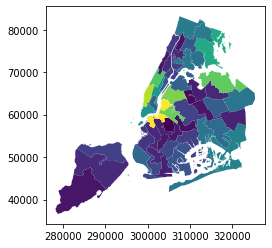

In [64]:
merged.plot(column=18.0)

In [65]:
merged = merged.to_crs('EPSG:4326')
merged.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [66]:
with open('districts_nyc.geojson', 'w') as f:
    f.write(merged.to_json())

## Interpolation (WIP)
This uses IDW interpolation to produce a raster showing sidewalk widths.

In [105]:
df_exploded['centerpoints'] = df_exploded['centerlines'].apply(interpolate)

In [106]:
df_exploded = df_exploded.set_geometry('centerpoints')

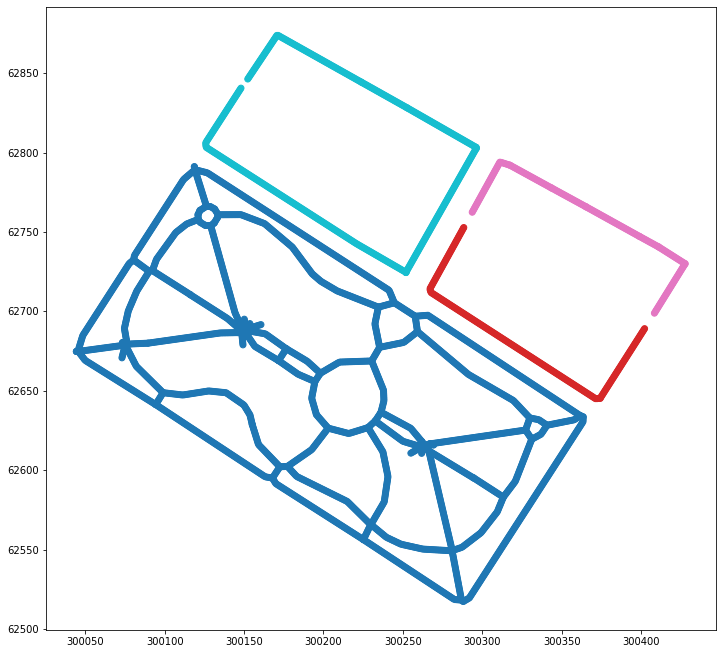

In [107]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [108]:
def polygon_to_multilinestring(polygon):

    return MultiLineString([polygon.exterior] + [line for line in polygon.interiors])
    

def get_distances(row):
    
    sidewalk_lines = polygon_to_multilinestring(row.geometry)
    
    distances = []
        
    for point in row.centerpoints:
        p1, p2 = nearest_points(sidewalk_lines, point)
        distances.append(p1.distance(p2))
        
    return distances

# def get_distances(row):
    
#     distances = []
    
#     for point in row.centerpoints:
#         p1, p2 = nearest_points(row['geometry'].exterior, point)
#         distances.append(p1.distance(p2))
        
#     return distances

In [109]:
df_exploded['distances'] = df_exploded.apply (lambda row: get_distances(row), axis=1)
df_exploded.head()

,,geometry,centerlines,segments,avg_distances,centerpoints,distances
0,0,"POLYGON ((300129.324 62788.206, 300133.617 627...","MULTILINESTRING ((300044.455 62674.781, 300044...",[LINESTRING (300044.4548079385 62674.780597435...,"[3.944050797707597, 3.9458902991567, 4.2991503...","MULTIPOINT (300044.456 62674.781, 300044.458 6...","[3.944050797707597, 3.9458902991567, 3.9465062..."
1,0,"POLYGON ((300352.245 62658.721, 300372.286 626...","MULTILINESTRING ((300374.215 62645.296, 300371...",[LINESTRING (300374.215385468 62645.2957090663...,"[1.7260281070217047, 1.2533334089373382, 1.900...","MULTIPOINT (300374.215 62645.296, 300373.221 6...","[2.246142450985554, 1.5780471887287824, 1.3823..."
2,0,"POLYGON ((300318.442 62793.146, 300323.717 627...","MULTILINESTRING ((300293.667 62762.429, 300311...",[LINESTRING (300293.6665799231 62762.428548577...,"[1.8960555255979048, 1.1022848798227356, 1.338...","MULTIPOINT (300293.667 62762.429, 300294.150 6...","[2.094754460453808, 2.0841900835227993, 2.0729..."
3,0,"POLYGON ((300174.039 62873.897, 300177.876 628...","MULTILINESTRING ((300148.074 62840.550, 300125...",[LINESTRING (300148.073897676 62840.5502664795...,"[1.3937061855904107, 1.0356144862327672, 1.417...","MULTIPOINT (300148.074 62840.550, 300147.531 6...","[1.4709434187253272, 1.4628160081723363, 1.454..."


In [110]:
data = {'feat_code': [], 'points': [], 'distance': []}

for i, row in df_exploded.iterrows():
    
    poly = row.geometry.exterior
    
    if row.centerpoints != None:
        for point in row.centerpoints:
            p1, p2 = nearest_points(poly, point)
        
            data['feat_code'].append(int(row.name[0]))
            data['points'].append(p2)
            data['distance'].append(p1.distance(p2))
        
df_points = pd.DataFrame(data)
df_points = GeoDataFrame(df_points, crs=crs, geometry='points')
df_points.head()

,feat_code,points,distance
0,0,POINT (300044.456 62674.781),3.944051
1,0,POINT (300044.458 62674.781),3.945890
2,0,POINT (300044.459 62674.781),3.946506
3,0,POINT (300045.436 62674.992),4.651794
4,0,POINT (300080.486 62732.410),2.996699


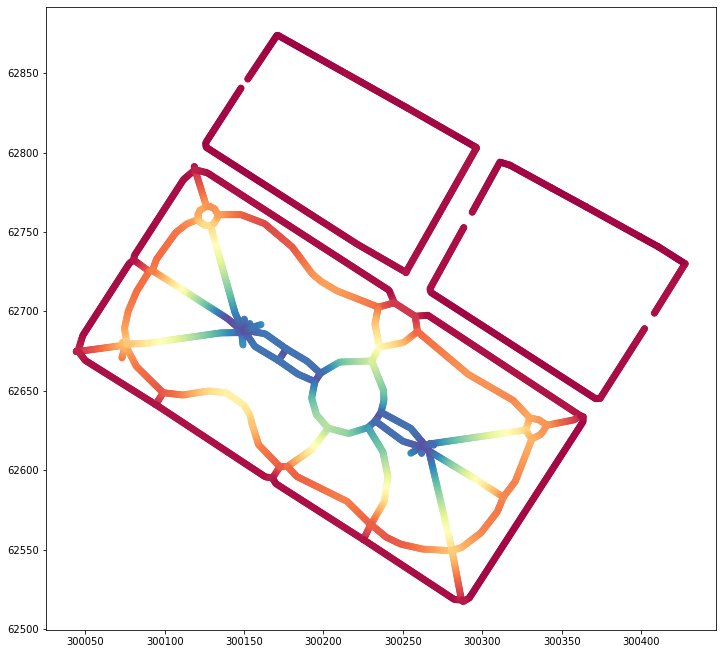

In [111]:
df_points.plot(column='distance', figsize=(12, 12), cmap='Spectral')

In [112]:
df_exploded.geometry.bounds

,,minx,miny,maxx,maxy
0,0,300044.455987,62517.363203,300363.509018,62791.094637
1,0,300267.164706,62645.075941,300402.173462,62752.800407
2,0,300293.666580,62698.882291,300427.688332,62793.943369
3,0,300125.903985,62724.447918,300296.202455,62873.754570


In [113]:
import scipy
from scipy.interpolate import griddata, interp2d, bisplrep, bisplev, Rbf
import matplotlib.pyplot as plt

import rasterio
import rasterio.features
from rasterio.transform import Affine

In [114]:
def idw(x, y, z, grid_x, grid_y, power):
    
    grid_z = np.zeros((grid_x.shape[0], grid_x.shape[1]), dtype='float32')
    
    for i in range(grid_x.shape[0]):
        
        for j in range(grid_x.shape[1]):
            
            distance = np.sqrt((x-grid_x[i, j])**2+(y-grid_y[i, j])**2)
            
            if (distance**power).min()==0: 
                
                grid_z[i,j] = z[(distance**power).argmin()]
            else:
                total = np.sum(1/(distance**power))
                grid_z[i,j] = np.sum(z/(distance**power)/total)
    
    return grid_z

def interpolate_points(row):
    
    if row.centerpoints.type == 'MultiPoint':
        px = np.array([point.coords.xy[0][0] for point in row.centerpoints.geoms])
        py = np.array([point.coords.xy[1][0] for point in row.centerpoints.geoms])
        pz = np.array([distance for distance in row.distances])
        
    else:
        print('not a multipoint')
    
    pixel_size = 1
    
    b = row.geometry.bounds
    x_count = round((b[2] - b[0]) / pixel_size)
    y_count = round((b[3] - b[1]) / pixel_size)
        
    x = np.linspace(b[0], b[2], x_count)
    y = np.linspace(b[1], b[3], y_count)
    grid_x, grid_y = np.meshgrid(x, y)
    
    grid_z = idw(px, py, pz, grid_x, grid_y, 4)
    
    fig1 = plt.figure(figsize=(12, 12))
    plt.axis('equal')
    plt.scatter(px, py, c=pz, vmin=0, vmax=4)
    x,y = row.geometry.exterior.xy
    plt.plot(x,y, c='black')
    
    fig2 = plt.figure(figsize=(12, 12))
    plt.axis('equal')
    plt.pcolormesh(grid_x, grid_y, grid_z, vmin=0, vmax=4)
    x,y = row.geometry.exterior.xy
    plt.plot(x,y, c='black')
    
    return fig1, fig2, b[0], b[1], grid_x, grid_y, grid_z

In [115]:
df_exploded.iloc[2].geometry.interiors

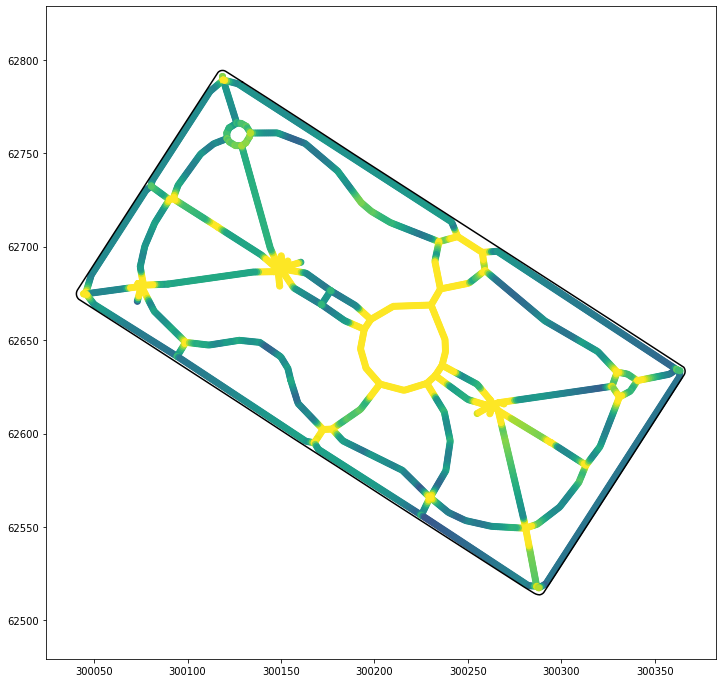

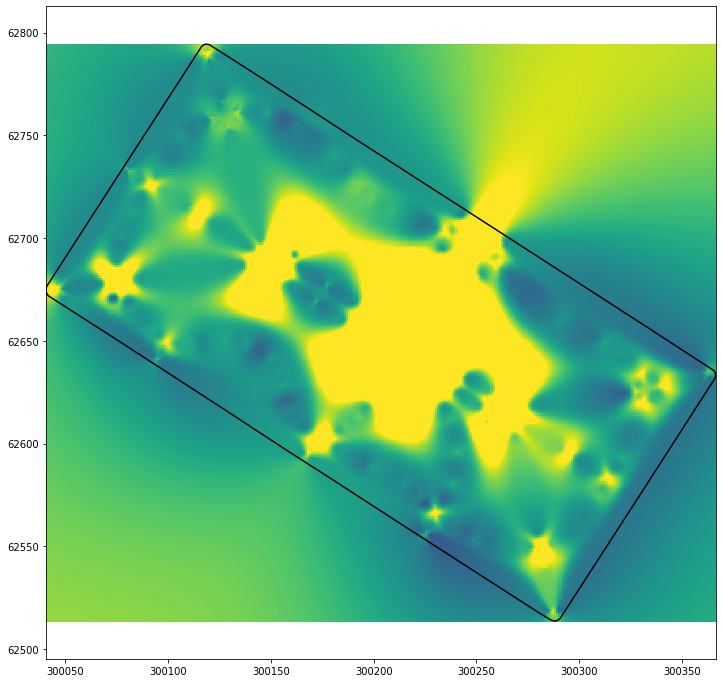

In [116]:
fig1, fig2, x, y, grid_x, grid_y, z = interpolate_points(df_exploded.iloc[0])

In [117]:
z.shape

(281, 326)

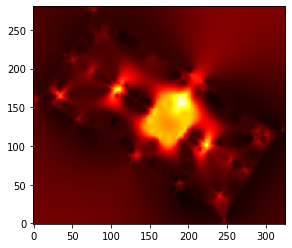

In [118]:
plt.imshow(z, origin='lower', cmap='hot')

In [119]:
# Get the color map by name:
cm = plt.get_cmap('viridis')

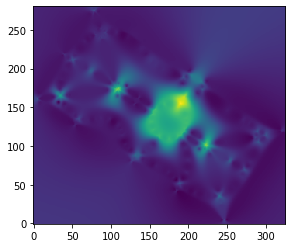

In [120]:
z1 = np.interp(z, (z.min(), z.max()), (0, 1))
plt.imshow(z1, origin='lower')

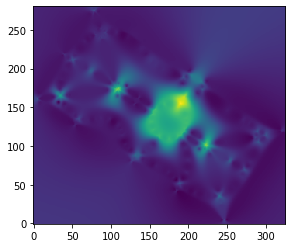

In [121]:
# Apply the colormap like a function to any array:
z2 = cm(z1)
plt.imshow(z2, origin='lower')

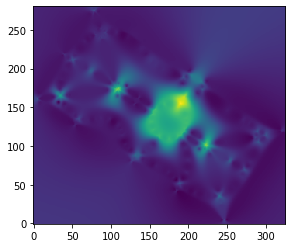

In [122]:
z3 = np.uint8(z2 * 255)
plt.imshow(z3, origin='lower')

In [123]:
plt.imshow(z, origin='lower', cmap='hot')
plt.axis('off')
plt.savefig('test2_hot.png')
plt.close()

In [93]:
z4 = np.moveaxis(z3, [0, 1, 2], [1, 2, 0])
z4.shape

(4, 281, 326)

In [38]:
crs = 'PROJCS["NAD83(NSRS2007) / New York Long Island",GEOGCS["NAD83(NSRS2007)",DATUM["NAD83_National_Spatial_Reference_System_2007",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6759"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4759"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",41.03333333333333],PARAMETER["standard_parallel_2",40.66666666666666],PARAMETER["latitude_of_origin",40.16666666666666],PARAMETER["central_meridian",-74],PARAMETER["false_easting",300000],PARAMETER["false_northing",0],AUTHORITY["EPSG","3627"],AXIS["X",EAST],AXIS["Y",NORTH]]'

raster = rasterio.open(
    './new.tif', 
    'w', 
    driver='GTiff', 
    height=z4.shape[1], 
    width=z4.shape[2], 
    count=4, 
    dtype=z4.dtype,
    crs=crs,
    transform=Affine.translation(x, y)
)

raster.write(z4)
raster.close()

In [39]:
raster.bounds

BoundingBox(left=299971.5446963901, bottom=58132.22361541897, right=300105.5446963901, top=58030.22361541897)

In [41]:
import fiona
from shapely.geometry import shape

# create a shapely geometry
# this is done for the convenience for the .bounds property only
geometry = shape(df_exploded.iloc[2].geometry)

# get pixel coordinates of the geometry's bounding box
ul = raster.index(*geometry.bounds[0:2])
lr = raster.index(*geometry.bounds[2:4])

# read the subset of the data into a numpy array
window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))

In [42]:
src = rasterio.open('new.tif')
src.read(1, window=window)

array([], shape=(0, 134), dtype=uint8)

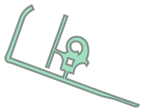

In [43]:
from rasterio.mask import mask

coords = df_exploded.iloc[2].geometry
coords

In [44]:
img, transform = mask(dataset=src, shapes=[coords], nodata=None, crop=False)

RasterioIOError: Read or write failed. PROJ: proj_create_from_database: Cannot find proj.db

In [45]:
result = img[0, :, :]
result.shape

NameError: name 'img' is not defined

NameError: name 'result' is not defined

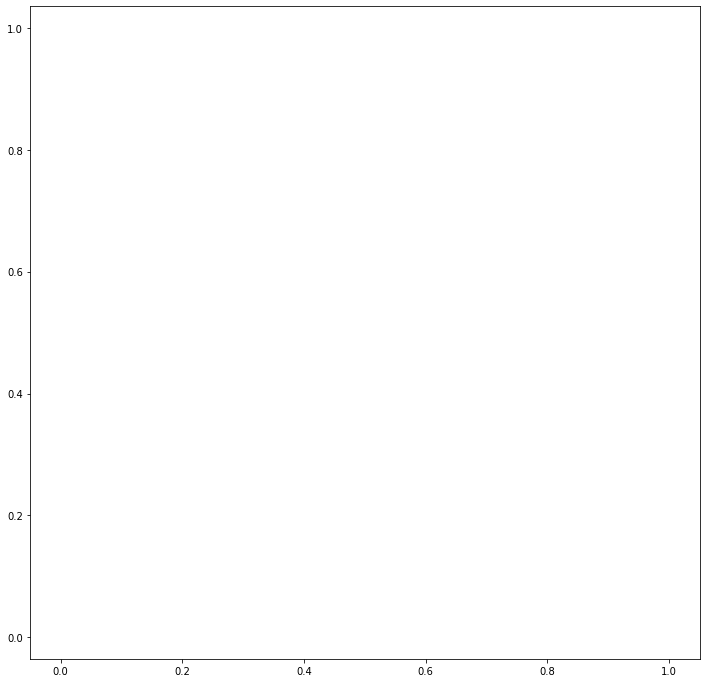

In [46]:
fig = plt.figure(figsize=(12, 12))
plt.axis('equal')
plt.pcolormesh(grid_x, grid_y, result, vmin=0, vmax=4)

In [646]:
transform

Affine(1.0, 0.0, 299971.5446963901,
       0.0, 1.0, 58030.22361541897)

In [647]:
raster = rasterio.open(
    './new_clipped.tif', 
    'w', 
    driver='GTiff', 
    height=result.shape[0], 
    width=result.shape[1], 
    count=1, 
    dtype=result.dtype,
    crs=crs,
    transform=transform
)

raster.write(result, 1)
raster.close()

In [632]:
import fiona
from shapely.geometry import shape

# create a shapely geometry
# this is done for the convenience for the .bounds property only
geometry = shape(df_exploded.iloc[2].geometry)

# get pixel coordinates of the geometry's bounding box
ul = raster.index(*geometry.bounds[0:2])
lr = raster.index(*geometry.bounds[2:4])

# read the subset of the data into a numpy array
window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
data = raster.read(1)

# create an affine transform for the subset data
t = raster.transform
shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

print(data.shape)

# rasterize the geometry
mask = rasterio.features.rasterize(
    [(geometry, 0)],
    out_shape=data.shape,
    transform=shifted_affine,
    fill=1,
    all_touched=True,
    dtype=np.uint8)

# create a masked numpy array
masked_data = np.ma.array(data=data, mask=mask.astype(bool))

# display some statistics
print('{}\nRange: {:.1f} to {:.1f}'.format(
    'feature',
    masked_data.min(),
    masked_data.max()))

UnsupportedOperation: not readable

IndexError: tuple index out of range

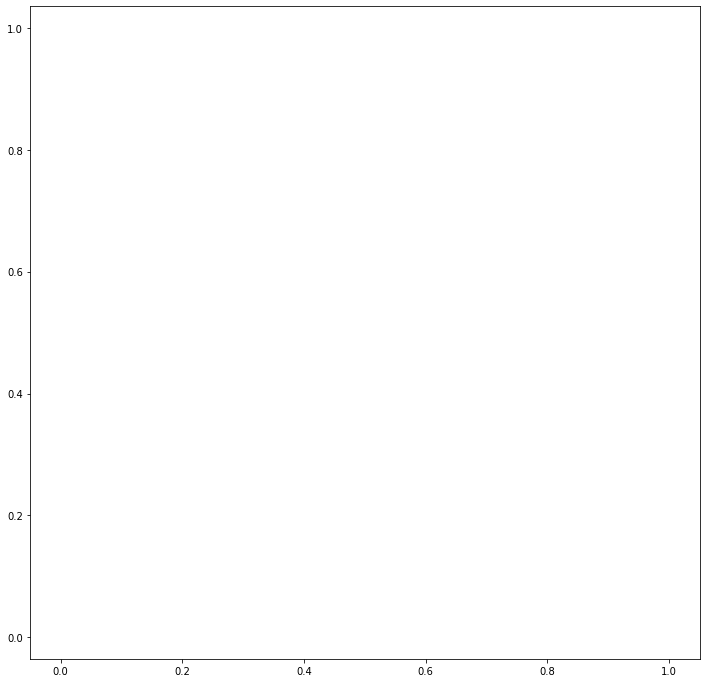

In [633]:
fig = plt.figure(figsize=(12, 12))
plt.axis('equal')
plt.pcolormesh(x, y, masked_data, vmin=0, vmax=4)